In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import skimage
import sys
sys.path.append("../../../../")
import utils
import os
from tqdm import tqdm
import torch
from skimage.io import imread
from scipy.io import loadmat
from skimage.measure import regionprops
from skimage.transform import resize
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import re
import graph
import scanpy as sc
import pandas as pd

/tmp/ipykernel_631779/3907776352.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfsub['y_centroid2'] = -1 * dfsub['y_centroid']


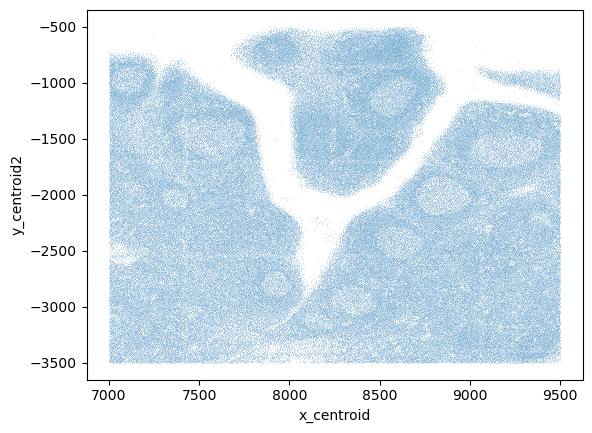

In [2]:
adata = sc.read_10x_h5(
    filename="../data/cell_feature_matrix.h5" # readin data from 10x website download
)
adata

df = pd.read_csv(
    "../data/cells.csv" # readin data from 10x website download
)
df.set_index(adata.obs_names, inplace=True)
adata.obs = df.copy()
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()
adata.obs.head()

# add barcode and subset regions
df['barcode'] = [x for x in range(1,df.shape[0]+1)]

dfsub = df.loc[(df.x_centroid > 7000) & (df.x_centroid < 9500) &
                          (df.y_centroid > 500) & (df.y_centroid < 3500),:]
dfsub['y_centroid2'] = -1 * dfsub['y_centroid']

import seaborn as sns
sns.scatterplot(dfsub, x = 'x_centroid', y = 'y_centroid2', s = 0.2)

adata_sub = adata[adata.obs_names.isin(dfsub.cell_id)]

In [3]:
adata_sub.obs = dfsub.copy()
adata_sub.obsm["spatial"] = adata_sub.obs[["x_centroid", "y_centroid"]].copy().to_numpy()
adata_sub.obs.head()

,cell_id,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area,barcode,y_centroid2
adkkpojc-1,adkkpojc-1,9079.155273,852.034607,210,0,0,0,0,210,388.343764,18.197969,21061,-852.034607
adklbgog-1,adklbgog-1,9053.489258,836.870728,84,0,0,0,0,84,651.920805,37.840939,21062,-836.870728
adklbigp-1,adklbigp-1,9055.033203,858.775208,70,0,0,0,0,70,85.209847,38.924689,21063,-858.775208
adklblhc-1,adklblhc-1,9071.123047,864.167419,187,0,0,0,0,187,67.418284,29.261251,21064,-864.167419
adklcljc-1,adklcljc-1,9058.196289,865.665100,83,0,0,0,0,83,61.909221,34.092970,21065,-865.665100


In [4]:
# filter cells and genes

sc.pp.filter_cells(adata_sub, min_counts=20)
sc.pp.filter_genes(adata_sub, min_cells=50)

In [5]:
adata_sub # removed 10k cells + ~100 genes

AnnData object with n_obs × n_vars = 158259 × 377
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'barcode', 'y_centroid2', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    obsm: 'spatial'

### quick check data quality

In [6]:
adata_sub.layers["counts"] = adata_sub.X.copy()
sc.pp.normalize_total(adata_sub, inplace=True)
sc.pp.log1p(adata_sub)
sc.pp.pca(adata_sub)
sc.pp.neighbors(adata_sub)
sc.tl.umap(adata_sub)
sc.tl.leiden(adata_sub)

/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


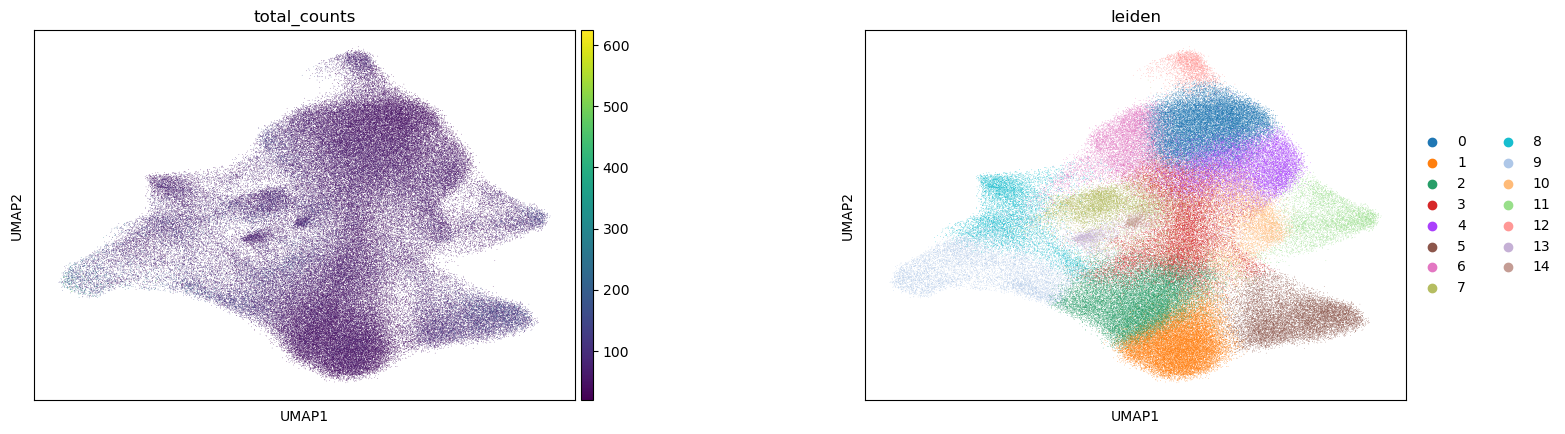

In [7]:
sc.pl.umap(
    adata_sub,
    color=[
        "total_counts",
        "leiden"
    ],
    wspace=0.4,
)

/tmp/ipykernel_631779/2386287374.py:4: UserWarning: 
The palette list has fewer values (13) than needed (15) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(adata_sub.obs, x = 'x_centroid', y = 'y_centroid2', hue = 'leiden', s = 0.1, palette=palette)


<AxesSubplot: xlabel='x_centroid', ylabel='y_centroid2'>

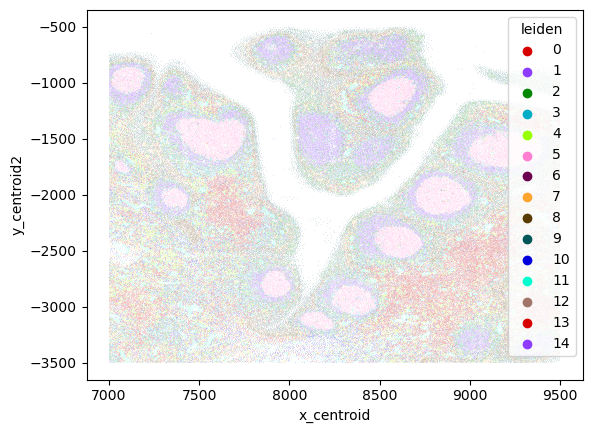

In [8]:
#adata_sub.obs
import colorcet as cc
palette = sns.color_palette(cc.glasbey, n_colors=13)
sns.scatterplot(adata_sub.obs, x = 'x_centroid', y = 'y_centroid2', hue = 'leiden', s = 0.1, palette=palette)

### start saving out stuff

In [9]:
xrln_meta = adata_sub.obs
xrln_meta.to_csv('../data/Xton_sub_meta.csv', index=False)

In [10]:
xrln_norm = pd.DataFrame(adata_sub.X.toarray())
xrln_norm.to_csv('../data/Xton_sub_norm.csv', index=False)

In [11]:
# save out gene names lol
pd.DataFrame(adata_sub.var_names.to_list()).to_csv('../data/gene_names.csv', index=False)


In [12]:
pc = adata_sub.obsm['X_pca']
xrln_pc = pd.DataFrame(pc)
xrln_pc.to_csv('../data/Xton_sub_pc.csv', index=False)

In [13]:
print([xrln_meta.shape, xrln_norm.shape, xrln_pc.shape])

[(158259, 15), (158259, 377), (158259, 50)]


#### save out the cellsnap required inputs

In [14]:
data_dir = '../data/'

features = adata_sub.obsm['X_pca'][:,:30] # top 30 PC

res = 0.5
knn = 20

feature_edges = graph.get_feature_edges(
    arr=features, pca_components=None, # no repeat PCA in this case
    n_neighbors=15, metric='correlation', verbose=False
)

feature_labels = graph.graph_clustering(
    features.shape[0], feature_edges, resolution=res, n_clusters=None, n_runs=1,
    resolution_tol=0.05, seed=None, verbose=False
)

np.save(os.path.join(data_dir, f'Xton_feature_labels_res{res}.npy'), feature_labels)
np.save(os.path.join(data_dir, f'Xton_feature_edges_res{res}.npy'), np.array(feature_edges[:2]).T)

print('Calculating cell neighborhood composition matrix...')

locations = xrln_meta[['x_centroid', 'y_centroid']].to_numpy()
spatial_knn_indices = graph.get_spatial_knn_indices(locations=locations, n_neighbors=knn, method='kd_tree')
cell_nbhd = utils.get_neighborhood_composition(knn_indices=spatial_knn_indices, labels=feature_labels)
np.save(os.path.join(data_dir, f'Xton_cell_nbhd_res{res}_k{knn}.npy'), cell_nbhd)

## save out spatial edge, always 15 cells
spatial_knn_indices = graph.get_spatial_knn_indices(locations=locations, n_neighbors=15, method='kd_tree')
np.save(os.path.join(data_dir, f'Xton_spatial_knn_indices_k15.npy'), spatial_knn_indices)

spatial_edges = graph.get_spatial_edges(
    arr=locations, n_neighbors=15, verbose=True
)
np.save(os.path.join(data_dir, f'Xton_spatial_edges.npy'), np.array(spatial_edges[:2]).T)

Calculating cell neighborhood composition matrix...
Constructing the graph...
Done!


In [15]:
len(np.unique(feature_labels))

8

### prep image

In [16]:
import pathlib
from pyometiff import OMETIFFReader
img_fpath = pathlib.Path("../data/morphology_focus.ome.tif")
reader = OMETIFFReader(fpath=img_fpath)
img_array, metadata, xml_metadata = reader.read()

Key not found: 'NoneType' object has no attribute 'iter'
Key not found: 'NoneType' object has no attribute 'iter'


In [17]:
pad = 600

## pad
zero_pad_entire_view = np.zeros((img_array.shape[0]+2*pad, img_array.shape[1]+2*pad))
zero_pad_entire_view[pad:img_array.shape[0]+pad, pad:img_array.shape[1]+pad] = img_array

###########

# truncate
truncate = np.quantile(zero_pad_entire_view, q = 0.8, axis = (0, 1))
zero_pad_entire_view[zero_pad_entire_view <= truncate] = 0
zero_pad_entire_view[zero_pad_entire_view > truncate] = 1

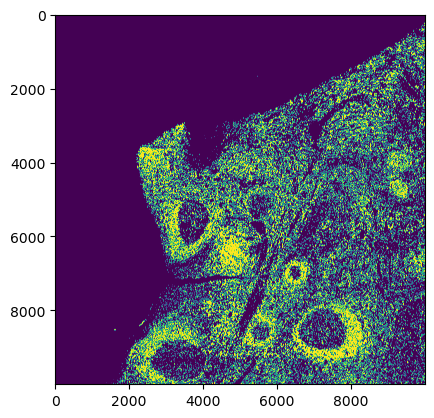

In [18]:
plt.imshow(zero_pad_entire_view[5000:15000,5000:15000])
plt.show()

In [19]:
dfsub_up = adata_sub.obs
dfsub_up.shape

(158259, 15)

In [20]:
zero_pad_entire_view.shape

(42069, 55126)

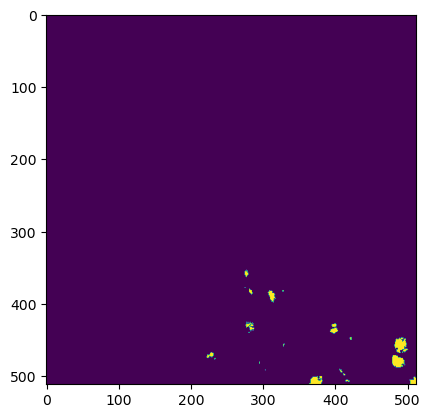

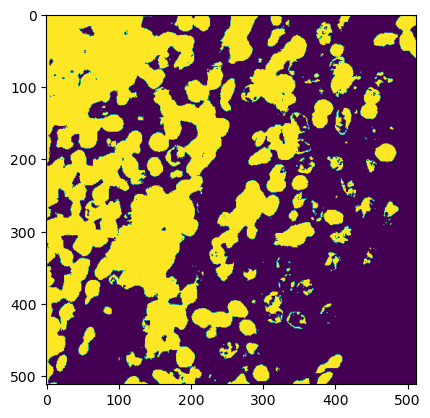

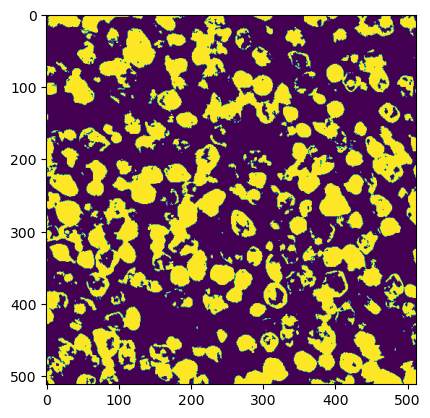

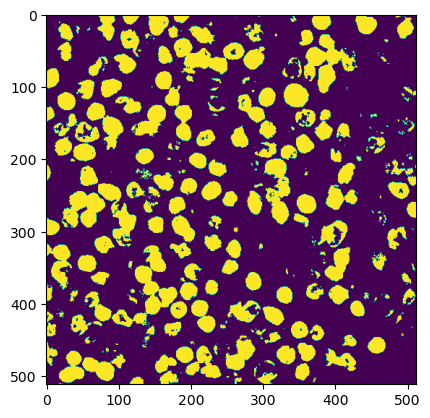

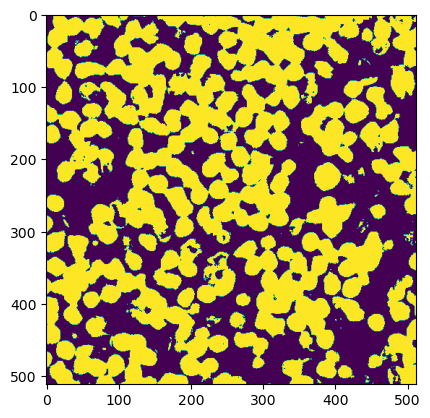

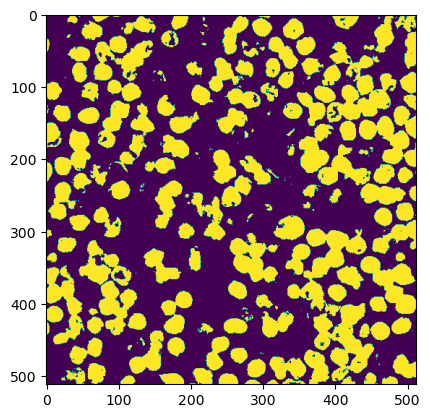

In [21]:
## then loop cells - take 20 mins
save_folder = '../data/images/'
size = 256 # 256 * 2 = 512 ~ 100um in physical distance

# 25778, 35416
img_idx = 0
for i in range(dfsub_up.shape[0]):
#for i in range(100):
    x = dfsub_up.iloc[i, 1] # load x and y locations
    y = dfsub_up.iloc[i, 2]

    ## linear projection of x y location
    rx = int(x / 0.2125 )
    ry = int(y / 0.2125 )

    padimg = np.transpose(zero_pad_entire_view[(ry-size+pad):(ry+size+pad),
                                               (rx-size+pad):(rx+size+pad)],(0, 1)).astype(np.int8)
    assert(padimg.shape == (size*2, size*2))
    padimg2 = np.expand_dims(padimg, axis=0)
    #print(padimg2.shape)
    np.save(file = os.path.join(save_folder, f"img_{img_idx:06d}"), arr = padimg2)

    if i % 30000 == 1:
        plt.imshow(padimg2[0,:,:])
        plt.show()

    img_idx += 1


In [22]:
dfsub_up.shape

(158259, 15)